# Refine labels for Memory CD8 T cells

In this notebook, we load all Memory CD8 T cells across our subjects to refine final L3 labels. We'll combine, recluster, and assign final labels by taking the most frequent AIFI_L3 label in each cluster, and back-propogate those L3 labels to L2 and L1 based on our cell type hierarcy.

We'll also generate metadata, UMAP coordinates, and marker gene summaries for review of our final labels, then store all of the outputs in HISE for later use.

Because there are many Memory CD8 T cells, we'll divide them into smaller subsets based on cohort, sex, and visit grouping (defined below). We'll combine CMV+ and CMV- subjects so that we better capture cell types that are enriched in CMV+ subjects. We'll then review each subset and assemble all labeled data in later notebooks.

## Load packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import tarfile

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
out_dir = 'output/review'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [4]:
class_name = 'memory_cd8_t_cell'

## Helper functions

### HISE data
These functions make it easy to utilize files from the HISE cache

In [5]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [6]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [7]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [8]:
def read_obs_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    obs = res.obs.copy()
    return obs

### Label refinement

This function uses the most frequent label within each cluster to refine label assignments.

In [9]:
def single_value(series):
    res = []
    for value in series:
        if isinstance(value, list):
            res.append(value[0])
        else:
            res.append(value)
    return res

In [10]:
def assign_most_frequent(adata, clusters, labels, keep_original = False, original_prefix = 'predicted_'):
    obs = adata.obs
    
    most_frequent_labels = (
        adata.obs
        .groupby(clusters)[labels]
        .agg(pd.Series.mode)
        .to_frame()
        .reset_index()
    )
    most_frequent_labels[labels] = single_value(most_frequent_labels[labels])
    
    if keep_original:
        obs = obs.rename({labels: original_prefix + labels}, axis = 1)
    else:
        obs = obs.drop(labels, axis = 1)
    
    obs = obs.merge(most_frequent_labels, on = clusters, how = 'left')
    
    adata.obs = obs
    
    return adata

This function can be used to update labels resulting from iterative subclustering.

In [48]:
def label_substitution(adata, labels):
    sub_idx = adata.obs['barcodes'].isin(labels['barcodes'])
    sub_adata = adata[sub_idx]
    
    adata = adata[[not x for x in sub_idx]]
    
    sub_obs = sub_adata.obs.drop(['AIFI_L3', 'predicted_AIFI_L3'], axis = 1)
    sub_obs = sub_obs.reset_index(drop = True)
    sub_obs = sub_obs.merge(labels, on = 'barcodes', how = 'left')
    sub_obs = sub_obs.set_index('barcodes', drop = False)
    sub_adata.obs = sub_obs
    
    adata = sc.concat([adata, sub_adata])
    return adata

This function back-propagates hierarchical labeling from AIFI_L3 back to AIFI_L2 and AIFI_L1 to ensure our labels agree across levels of our cell type hierarchy.

In [11]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')
    
    adata.obs = obs

    return adata

### Review outputs

These functions are used to assemble marker gene expression tables for review

In [12]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def marker_mean_df(adata, markers, log = False, clusters = 'louvain_2'):
    gene_cl_mean = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True,
        log = log
    ).dot_color_df
    
    return gene_cl_mean

def tidy_marker_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, markers, clusters)
    gene_cl_frac = gene_cl_frac.reset_index(drop = False)
    gene_cl_frac = pd.melt(gene_cl_frac, id_vars = clusters, var_name = 'gene', value_name = 'gene_frac')
    
    gene_cl_mean = marker_mean_df(adata, markers, log = False, clusters = clusters)
    gene_cl_mean = gene_cl_mean.reset_index(drop = False)
    gene_cl_mean = pd.melt(gene_cl_mean, id_vars = clusters, var_name = 'gene', value_name = 'gene_mean')

    marker_df = gene_cl_frac.merge(gene_cl_mean, on = [clusters, 'gene'], how = 'left')
    return marker_df

This function will select clusters based on gene detection above a specifiec fraction of cells (cutoff).

In [13]:
def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

This function retrieves both observations and UMAP coordinates in a single table for review.

In [65]:
def obs_with_umap(adata):
    obs = adata.obs.copy()
    
    umap_mat = adata.obsm['X_umap']
    umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])

    obs = obs.reset_index(drop = True)
    obs['umap_1'] = umap_df['umap_1']
    obs['umap_2'] = umap_df['umap_2']

    return obs

This function applies data analysis methods to our scRNA-seq data, including normalization, HVG selection, PCA, nearest neighbors, UMAP, and Leiden clustering.

In [15]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')

    print('Harmony', end = "; ")
    # Integrate subjects
    sce.pp.harmony_integrate(
        adata, 
        'subject.subjectGuid',
        max_iter_harmony = 30,
        verbose = False
    )
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 50,
        n_pcs = 30,
        use_rep = 'X_pca_harmony'
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 2
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

In [16]:
def isg_hi_refinement(adata, clusters = 'leiden_2', refine_res = 2):
    isg_hi_cl = select_clusters_above_gene_frac(
        adata, 'IFI44L', 0.3, clusters = clusters
    )
    print(isg_hi_cl)
    
    isg_adata = adata[adata.obs[clusters].isin(isg_hi_cl)]
    
    isg_adata = process_adata(isg_adata, resolution = refine_res)
    isg_adata = assign_most_frequent(
        isg_adata, 
        'leiden_{r}'.format(r = refine_res), 'AIFI_L3',
        keep_original = True,
        original_prefix = 'predicted_'
    )

    isg_df = isg_adata.obs[['barcodes', 'AIFI_L3', 'predicted_AIFI_L3']]
    return isg_df

## Cell Type Markers

These are the set of marker genes that we'll use to review our cell type labels.

In [17]:
l2_markers = [
    'CD3E', 'CD4', 'CD8A', 'TRAC', 'TRDC', 
    'LEF1', 'TCF7', 'CCR7', 'SELL', 'ITGB1', 
    'FAS', 'CD27', 'CD28', 'FOXP3', 'RTKN2', 
    'IKZF2', 'ZNF683', 'NKG7', 'KLRC2', 'KLRF1', 
    'KLRB1', 'KLRD1', 'GZMA', 'GZMK', 'GZMB', 
    'PRF1', 'GNLY', 'IFI44L', 'IRF7', 'MKI67', 
    'TRDV1', 'TRDV2', 'TRDV3', 'MME', 'SOX4'
]

l3_markers = [
    'CD27', 'CD28', 'KLRF1', 'KLRB1', 'KLRD1', 
    'KLRC1', 'KLRC2', 'GZMA', 'GZMB', 'GZMK', 
    'GZMH', 'PRF1', 'CCL5', 'GNLY', 'GATA3', 
    'TBX21', 'EOMES', 'LEF1', 'TCF7', 'IKZF2',
    'SOX4', 'IFI44L'
]

## Read cell type hierarchy from HISE

As part of label refinement, we'll back-propagate our cell type labels from refined AIFI_L3 labels to their parent cell classes at AIFI_L2 and AIFI_L1. To do this, we need the hierarchical relationships between these levels, which have been generated for our cell type reference dataset.

In [18]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files in HISE

For this analysis, we'll read in these files from HISE storage from previous steps. We'll group these into "large" files, which are from the set of 5 very large cell type assignments, and "small" files, which are from other cell types.

In [19]:
h5ad_uuids = {
    'BR1_Female_Negative_Memory-CD8-T-cell': 'de83b600-3cc6-40ba-acb6-613c12e178ac',
    'BR1_Female_Positive_Memory-CD8-T-cell': 'aa8b8b0f-164f-4fba-8af9-8397d9e67cd7',
    'BR1_Male_Negative_Memory-CD8-T-cell': '8cc6a9b1-0ec7-445e-8299-556a4f95cb66',
    'BR1_Male_Positive_Memory-CD8-T-cell': 'df7c9a0a-3b5e-48d9-91de-2bd424daa44a',
    'BR2_Female_Negative_Memory-CD8-T-cell': 'b8550f9d-b4aa-4ba7-955b-cf556fabb21d',
    'BR2_Female_Positive_Memory-CD8-T-cell': 'd76d8ee6-6b85-42e4-9974-36c6ef4b0538',
    'BR2_Male_Negative_Memory-CD8-T-cell': '10d6ff38-dabd-4439-90e4-28d2c932d81f',
    'BR2_Male_Positive_Memory-CD8-T-cell': '37d23649-4670-4ac2-9dd0-e0de0fce573d',
}

## Read and process data

In [20]:
out_file = 'output/diha_{c}_AIFI_L3_review_{d}.h5ad'.format(c = class_name, d = date.today())
out_review = []

adata_list = []
for group_name, uuid in h5ad_uuids.items():
    group_adata = read_adata_uuid(uuid)
    print('{g}: {n} cells'.format(g = group_name, n = group_adata.shape[0]))
    adata_list.append(group_adata)
    
adata = sc.concat(adata_list)
print('Total: {n} cells'.format(n = adata.shape[0]))
del adata_list

BR1_Female_Negative_Memory-CD8-T-cell: 158252 cells
BR1_Female_Positive_Memory-CD8-T-cell: 160891 cells
BR1_Male_Negative_Memory-CD8-T-cell: 132362 cells
BR1_Male_Positive_Memory-CD8-T-cell: 189102 cells
BR2_Female_Negative_Memory-CD8-T-cell: 78384 cells
BR2_Female_Positive_Memory-CD8-T-cell: 399129 cells
BR2_Male_Negative_Memory-CD8-T-cell: 173486 cells
BR2_Male_Positive_Memory-CD8-T-cell: 195401 cells
Total: 1487007 cells


In [21]:
adata = process_adata(adata, resolution = 2)

Normalizing; Finding HVGs; Scaling; PCA; Harmony; 

2024-04-08 02:56:52,997 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-08 03:03:22,831 - harmonypy - INFO - sklearn.KMeans initialization complete.


Neighbors; Leiden; UMAP; Renormalizing


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


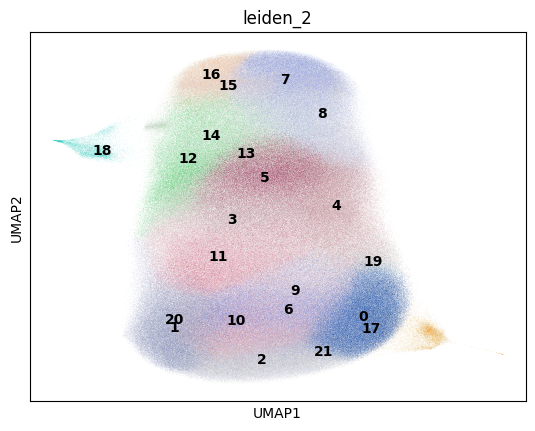

In [23]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


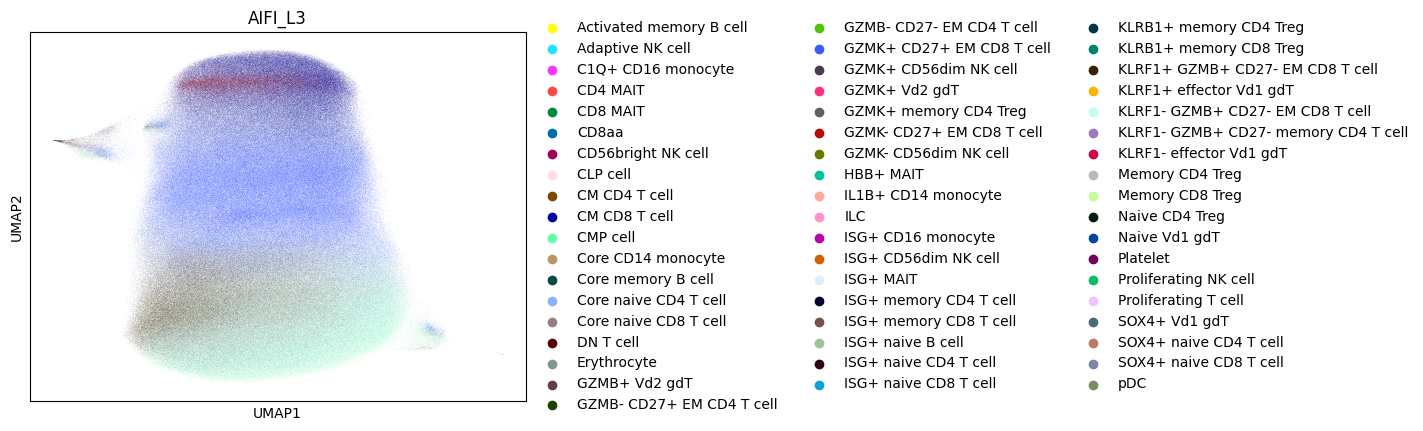

In [24]:
sc.pl.umap(adata, color = 'AIFI_L3')

In [37]:
hierarchy_df[hierarchy_df['AIFI_L2'] == 'Memory CD8 T cell']

,Unnamed: 0,AIFI_L1,AIFI_L2,AIFI_L3
47,47,T cell,Memory CD8 T cell,CM CD8 T cell
48,48,T cell,Memory CD8 T cell,GZMK+ CD27+ EM CD8 T cell
49,49,T cell,Memory CD8 T cell,GZMK- CD27+ EM CD8 T cell
50,50,T cell,Memory CD8 T cell,ISG+ memory CD8 T cell
51,51,T cell,Memory CD8 T cell,KLRF1+ GZMB+ CD27- EM CD8 T cell
52,52,T cell,Memory CD8 T cell,KLRF1- GZMB+ CD27- EM CD8 T cell


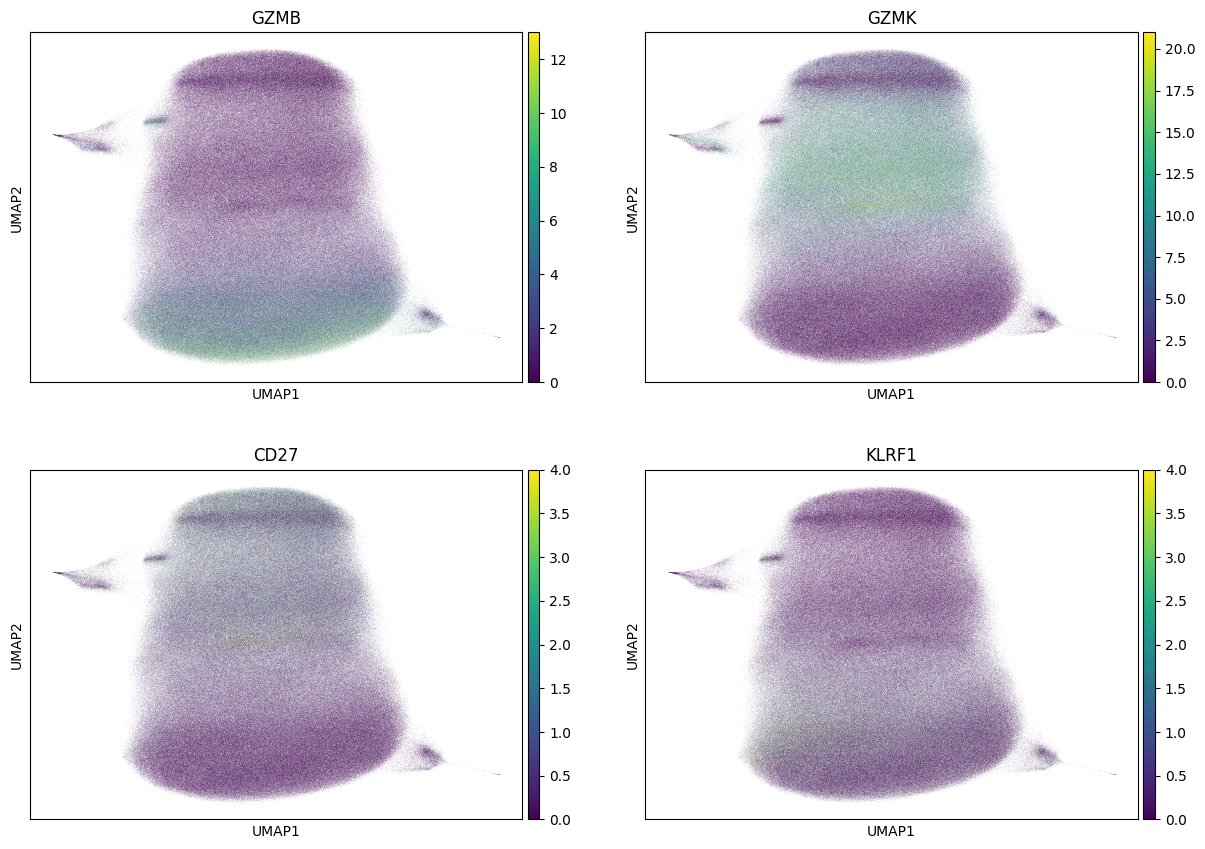

In [35]:
sc.pl.umap(adata, color = ['GZMB','GZMK','CD27','KLRF1'], ncols = 2, vmax = 'p99')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


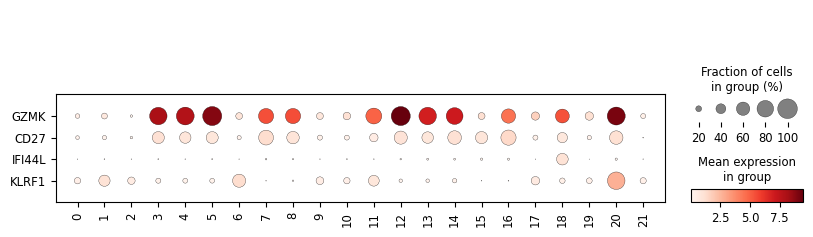

In [42]:
sc.pl.dotplot(
    adata,
    groupby = 'leiden_2',
    var_names = ['GZMK','CD27','IFI44L','KLRF1'],
    swap_axes = True
)

In [44]:
# Refine ISG-high clusters
isg_labels = isg_hi_refinement(adata, clusters = 'leiden_2', refine_res = 2)
isg_labels['AIFI_L3'].value_counts()

['18']


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; 

2024-04-08 05:42:21,365 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Harmony; 

2024-04-08 05:42:31,025 - harmonypy - INFO - sklearn.KMeans initialization complete.


Neighbors; Leiden; UMAP; Renormalizing


AIFI_L3
GZMK+ CD27+ EM CD8 T cell           5345
ISG+ memory CD8 T cell              4710
KLRF1- GZMB+ CD27- EM CD8 T cell    4444
Name: count, dtype: int64

In [45]:
# Refine labels based on in-group clustering
adata = assign_most_frequent(
    adata, 
    'leiden_2', 'AIFI_L3', 
    keep_original = True, 
    original_prefix = 'predicted_'
)

In [49]:
# Inject the ISG-hi labels
adata = label_substitution(adata, isg_labels)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


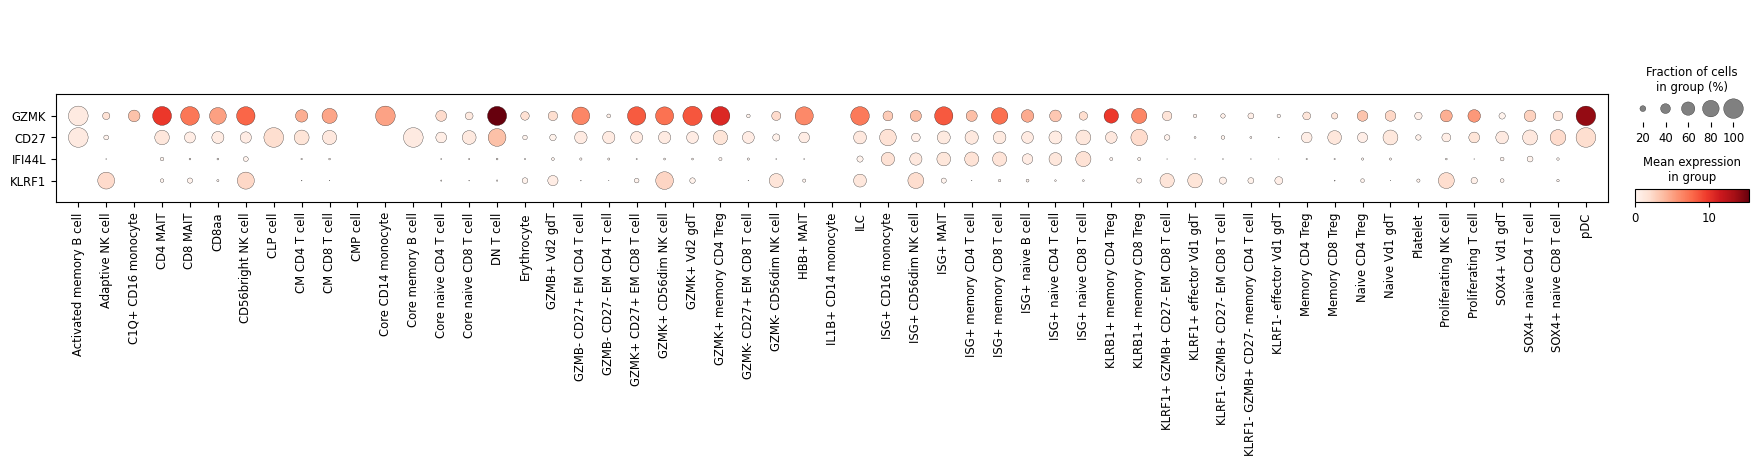

In [50]:
sc.pl.dotplot(
    adata,
    groupby = 'predicted_AIFI_L3',
    var_names = ['GZMK','CD27','IFI44L','KLRF1'],
    swap_axes = True
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


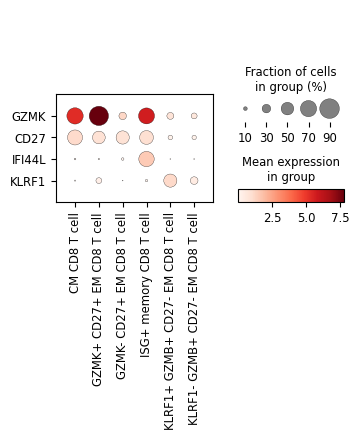

In [51]:
sc.pl.dotplot(
    adata,
    groupby = 'AIFI_L3',
    var_names = ['GZMK','CD27','IFI44L','KLRF1'],
    swap_axes = True
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


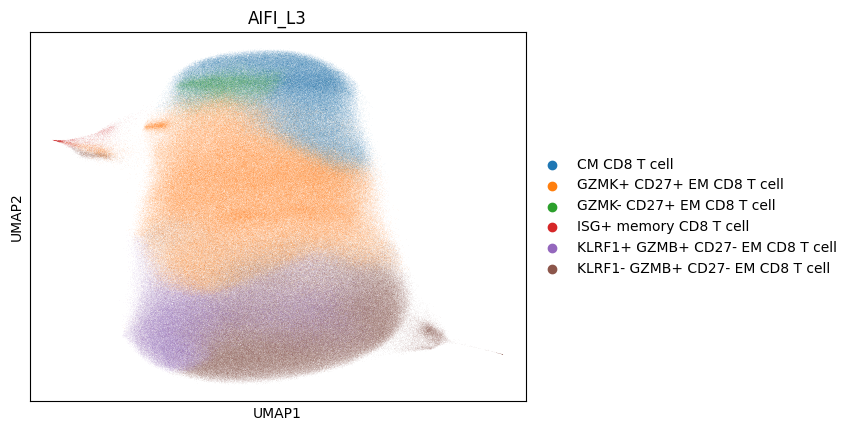

In [52]:
sc.pl.umap(adata, color = 'AIFI_L3')

## Save results to disk

In [53]:
# Save results for this visit group
adata.write_h5ad(out_file)

In [68]:
# Save metadata and UMAP
meta_csv = 'output/review/diha_{c}_AIFI_L3_review_meta_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
visit_group_obs = obs_with_umap(adata)
visit_group_obs.to_csv(meta_csv)
out_review.append(meta_csv)

# Save marker expression summaries
out_l2_markers = 'output/review/diha_{c}_AIFI_L2_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l2_marker_df = tidy_marker_df(
    adata,
    l2_markers,
    'AIFI_L2'
)
l2_marker_df.to_csv(out_l2_markers)
out_review.append(out_l2_markers)

out_l3_markers = 'output/review/diha_{c}_AIFI_L3_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l3_marker_df = tidy_marker_df(
    adata,
    l3_markers,
    'AIFI_L3'
)
l3_marker_df.to_csv(out_l3_markers)
out_review.append(out_l3_markers)

## Assemble output files for upload

### h5ad files

In [69]:
h5ad_files = [out_file]

### Review files

In [70]:
rev_files = os.listdir('output/review')
review_files = []
for rev_file in rev_files:
    if class_name in rev_file:
        review_files.append('{d}/{f}'.format(d = 'output/review', f = rev_file))

### Combine metadata files to assemble a full set

In [71]:
meta_files = []
for review_file in review_files:
    if 'meta' in review_file:
        meta_files.append(review_file)

meta_list = []
for meta_file in meta_files:
    meta_list.append(pd.read_csv(meta_file, index_col = 0))
all_meta = pd.concat(meta_list)

In [72]:
meta_csv = 'output/diha_{c}_AIFI_L3_refinement_meta_{d}.csv'.format(c = class_name, d = date.today())
all_meta.to_csv(meta_csv)
meta_parquet = 'output/diha_{c}_AIFI_L3_refinement_meta_{d}.parquet'.format(c = class_name, d = date.today())
all_meta.to_parquet(meta_parquet)

### Bundle review files into a .tar for later use

In [73]:
review_tar = 'output/diha_{c}_AIFI_L3_refinement_review_{d}.tar.gz'.format(c = class_name, d = date.today())
tar = tarfile.open(review_tar, 'w:gz')
for review_file in review_files:
    tar.add(review_file)
tar.close()

## Upload assembled results to HISE

In [80]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA Memory CD8 AIFI_L3 Refinement {d}'.format(d = date.today())

In [81]:
in_files = []
for group_name, uuid in h5ad_uuids.items():
    in_files.append(uuid)
in_files

['de83b600-3cc6-40ba-acb6-613c12e178ac',
 'aa8b8b0f-164f-4fba-8af9-8397d9e67cd7',
 '8cc6a9b1-0ec7-445e-8299-556a4f95cb66',
 'df7c9a0a-3b5e-48d9-91de-2bd424daa44a',
 'b8550f9d-b4aa-4ba7-955b-cf556fabb21d',
 'd76d8ee6-6b85-42e4-9974-36c6ef4b0538',
 '10d6ff38-dabd-4439-90e4-28d2c932d81f',
 '37d23649-4670-4ac2-9dd0-e0de0fce573d']

In [82]:
out_files = h5ad_files + [meta_csv, meta_parquet, review_tar]

In [83]:
out_files

['output/diha_memory_cd8_t_cell_AIFI_L3_review_2024-04-08.h5ad',
 'output/diha_memory_cd8_t_cell_AIFI_L3_refinement_meta_2024-04-08.csv',
 'output/diha_memory_cd8_t_cell_AIFI_L3_refinement_meta_2024-04-08.parquet',
 'output/diha_memory_cd8_t_cell_AIFI_L3_refinement_review_2024-04-08.tar.gz']

In [84]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = 'all_memory_cd8_refinement'
)

output/diha_memory_cd8_t_cell_AIFI_L3_review_2024-04-08.h5ad
output/diha_memory_cd8_t_cell_AIFI_L3_refinement_meta_2024-04-08.csv
output/diha_memory_cd8_t_cell_AIFI_L3_refinement_meta_2024-04-08.parquet
output/diha_memory_cd8_t_cell_AIFI_L3_refinement_review_2024-04-08.tar.gz
you are trying to upload file_ids... ['output/diha_memory_cd8_t_cell_AIFI_L3_review_2024-04-08.h5ad', 'output/diha_memory_cd8_t_cell_AIFI_L3_refinement_meta_2024-04-08.csv', 'output/diha_memory_cd8_t_cell_AIFI_L3_refinement_meta_2024-04-08.parquet', 'output/diha_memory_cd8_t_cell_AIFI_L3_refinement_review_2024-04-08.tar.gz']. Do you truly want to proceed?


(y/n) y


{'trace_id': '78510b02-8009-4082-a850-ec6fe63da9dd',
 'files': ['output/diha_memory_cd8_t_cell_AIFI_L3_review_2024-04-08.h5ad',
  'output/diha_memory_cd8_t_cell_AIFI_L3_refinement_meta_2024-04-08.csv',
  'output/diha_memory_cd8_t_cell_AIFI_L3_refinement_meta_2024-04-08.parquet',
  'output/diha_memory_cd8_t_cell_AIFI_L3_refinement_review_2024-04-08.tar.gz']}

In [85]:
import session_info
session_info.show()